# 04 – Performance Analysis & Comparison

This notebook corresponds to the original `performance_analysis`:

- Load portfolio return and IC series for:
  - Unhedged reversal
  - SPY-hedged reversal
  - SPY-hedged 12M–1M momentum
- Use `performance.summarize_portfolio_performance` and `build_summary_table`
  to create the final comparison table.
- Use `plotting` helpers to visualize equity curves and IC behavior.


In [4]:
from pathlib import Path

import pandas as pd
import matplotlib.pyplot as plt

from stat_arb import config, performance, plotting

paths_cfg = config.get_paths_config()
data_cfg = paths_cfg.get("data", {})
processed_dir = Path(data_cfg.get("processed_dir", "data/processed"))

processed_dir

PosixPath('data/processed')

In [5]:
# Unhedged reversal
unhedged_dir = processed_dir / "unhedged_reversal"
unhedged_ret = pd.read_parquet(unhedged_dir / "portfolio_returns.parquet")
unhedged_ic = pd.read_parquet(unhedged_dir / "rank_ic.parquet").iloc[:, 0]
unhedged_ic.name = "rank_ic_unhedged"

# SPY-hedged reversal
spy_hedged_dir = processed_dir / "spy_hedged_reversal"
spy_hedged_ret = pd.read_parquet(spy_hedged_dir / "portfolio_returns.parquet")
spy_hedged_ic = pd.read_parquet(spy_hedged_dir / "rank_ic.parquet").iloc[:, 0]
spy_hedged_ic.name = "rank_ic_spy_hedged"

# Optional: SPY-hedged momentum (if saved)
spy_hedged_mom_dir = processed_dir / "spy_hedged_momentum"
if (spy_hedged_mom_dir / "portfolio_returns.parquet").exists():
    spy_hedged_mom_ret = pd.read_parquet(spy_hedged_mom_dir / "portfolio_returns.parquet")
    spy_hedged_mom_ic = pd.read_parquet(spy_hedged_mom_dir / "rank_ic.parquet").iloc[:, 0]
    spy_hedged_mom_ic.name = "rank_ic_spy_hedged_mom"
else:
    spy_hedged_mom_ret = None
    spy_hedged_mom_ic = None

unhedged_ret.head(), spy_hedged_ret.head(), spy_hedged_mom_ret.head() if spy_hedged_mom_ret is not None else None

(            portfolio_ret
 Date                     
 2016-01-04      -0.006169
 2016-01-05      -0.013901
 2016-01-06      -0.025955
 2016-01-07      -0.001066
 2016-01-08       0.010682,
             portfolio_ret
 Date                     
 2016-01-04      -0.000309
 2016-01-05      -0.016605
 2016-01-06      -0.027424
 2016-01-07       0.015727
 2016-01-08       0.004586,
             portfolio_ret
 Date                     
 2016-01-04            NaN
 2016-01-05            NaN
 2016-01-06            NaN
 2016-01-07            NaN
 2016-01-08            NaN)

### Summaries

In [9]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

unhedged_summary = performance.summarize_portfolio_performance(
    portfolio_returns=unhedged_ret,
    ic_series=unhedged_ic,
    periods_per_year=252,
)

spy_hedged_summary = performance.summarize_portfolio_performance(
    portfolio_returns=spy_hedged_ret,
    ic_series=spy_hedged_ic,
    periods_per_year=252,
)

if spy_hedged_mom_ret is not None:
    spy_hedged_mom_summary = performance.summarize_portfolio_performance(
        portfolio_returns=spy_hedged_mom_ret,
        ic_series=spy_hedged_mom_ic,
        periods_per_year=252,
    )
else:
    spy_hedged_mom_summary = None

name_to_summary = {
    "Unhedged Reversal": unhedged_summary,
    "SPY-Hedged Reversal": spy_hedged_summary,
}

if spy_hedged_mom_summary is not None:
    name_to_summary["SPY-Hedged 12M-1M Momentum"] = spy_hedged_mom_summary

summary_table = performance.build_summary_table(name_to_summary)
summary_table

,Mean IC,IC Hit Rate,Cumulative Return,Sharpe,Max Drawdown
Strategy,,,,,
Unhedged Reversal,0.010950,0.527622,-0.982390,-1.007723,-0.996175
SPY-Hedged Reversal,0.012863,0.531625,-0.975342,-0.884403,-0.995067
SPY-Hedged 12M-1M Momentum,0.016799,0.566533,7.218043,0.481771,-0.390824


### Equity curves comparison

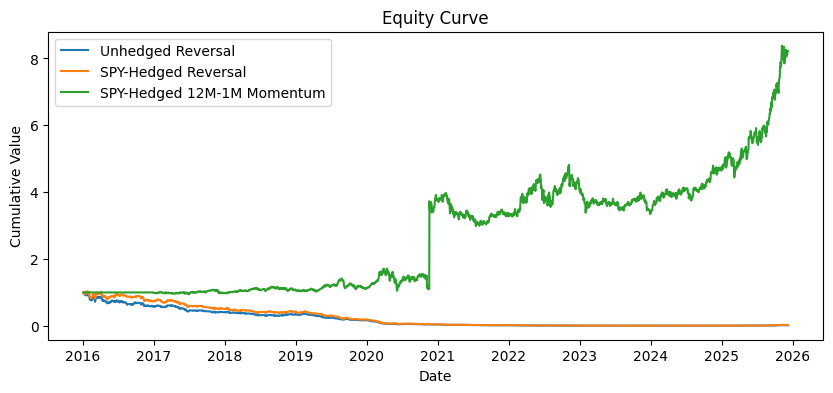

In [10]:
fig, ax = plt.subplots(figsize=(10, 4))

plotting.plot_equity_curve(unhedged_ret, ax=ax, label="Unhedged Reversal")
plotting.plot_equity_curve(spy_hedged_ret, ax=ax, label="SPY-Hedged Reversal")

if spy_hedged_mom_ret is not None:
    plotting.plot_equity_curve(spy_hedged_mom_ret, ax=ax, label="SPY-Hedged 12M-1M Momentum")

ax.legend()
plt.show()

### IC by year for each category

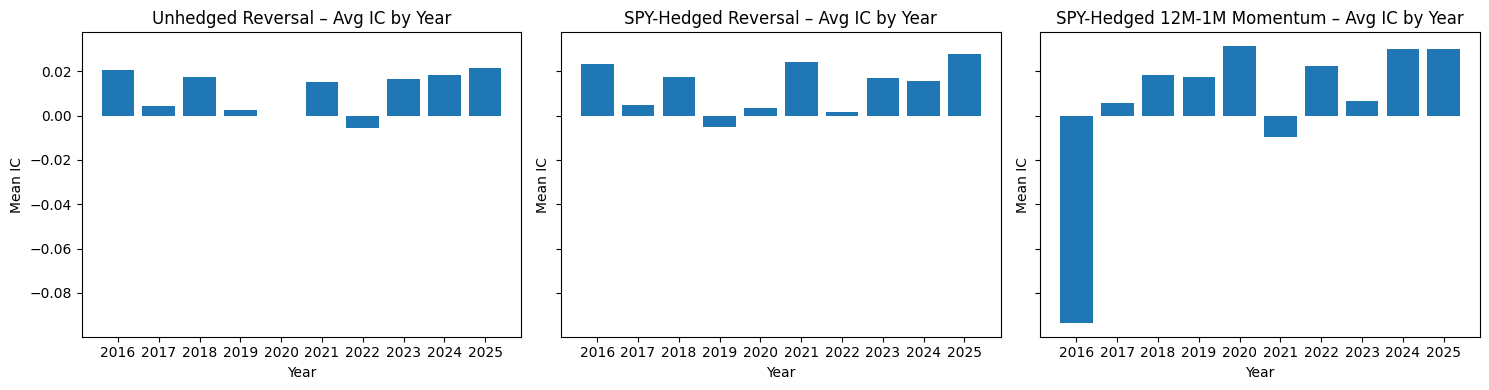

In [11]:
fig, axes = plt.subplots(1, 3 if spy_hedged_mom_ic is not None else 2, figsize=(15, 4), sharey=True)

plotting.plot_ic_by_year(unhedged_ic, ax=axes[0])
axes[0].set_title("Unhedged Reversal – Avg IC by Year")

plotting.plot_ic_by_year(spy_hedged_ic, ax=axes[1])
axes[1].set_title("SPY-Hedged Reversal – Avg IC by Year")

if spy_hedged_mom_ic is not None:
    plotting.plot_ic_by_year(spy_hedged_mom_ic, ax=axes[2])
    axes[2].set_title("SPY-Hedged 12M-1M Momentum – Avg IC by Year")

plt.tight_layout()
plt.show()

In [ ]:
## EOF